# Project-5: SNOTEL Water Level Analysis

##### Grant Hicks, Kathleen Wang, Samuel Yeager
--------

#### Imports

In [1]:
import os
import pandas as pd
import numpy as np
from IPython.core import display as ICD

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV, train_test_split
import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Supressing warnings on models
import warnings
warnings.filterwarnings("ignore")

### Problem Statement
The National Resources Conservation Service keeps track of precipitation levels in water basins across the Western United States using an automated system known as SNOTEL. This information is critical for resource management and provides insight on the climate status in the regions where the data is gathered. Understanding what areas may be experiencing abnormalities can be key  for planning resource management operations. Our goal is to determine if we can produce a model to predict precipitation levels in a water basin using data gathered from NRCS SNOTEL sites. 

----------------------------

### Contents
- Background
- Data Imports And Cleaning
- Exploratory Data Analysis and Data Visualization
- ARIMA Model
- Conclusions and Recommendations

## Background
#### SNOTEL
The Natural Resources Conservation Service (NRCS) uses an automated system to collect snowpack and climate data in the Western United States known as SNOTEL (SNOwpack TELemetry). Growing from a manual measurement system SNOTEL has been reliably collecting data to produce water supply forecasts and support resource management activities since 1980. SNOTEL uses meteor burst communications to collect and communicate data in near real time without the use of satellites. There are more than 730 SNOTEL sites in 11 states, all designed to operate without maintenance for a year as they are typically in remote locations and maintenance trips can involve long hikes or helicopter trips. The NRCS National Water and Climate Center in Portland, Oregon houses the central computer that controls operation of the sites and receives the data gathered.

|                  More information on SNOTEL can be found at the following links                  |
|:------------------------------------------------------------------------------------------------:|
| [SNOTEL Data Collection Network Fact Sheet](https://www.wcc.nrcs.usda.gov/factpub/sntlfct1.html) |
| [SNOTEL Brochure](https://www.wcc.nrcs.usda.gov/snotel/snotel_brochure.pdf)                      |
| [Snow Telemetry and Snow Course Data and Products](https://www.wcc.nrcs.usda.gov/snow/)          |

Our main focus was to look at the current reported precipitation level as well as the precipitation year to date for each site.

--------------------------

## Data Imports and Cleaning
Data used contains data from SNOTEL sites in the Columbia River Basin on February 10th from the years 1990 - 2021.

SNOTEL Snow/Precipitation Update Reports were gathered [here](https://wcc.sc.egov.usda.gov/reports/SelectUpdateReport.html).

#### Data Dictionary
|Feature                 |Description                                             |
|------------------------|--------------------------------------------------------|
| Lat                    | Decimal Latitude of SNOTEL Site                        |
| Long                   | Decimal Latitude of SNOTEL Site                        |
| YYYYMMDD               | Date of Observation                                    |
| Basin_name             | SNOTEL Site Sub-basin Name                             |
| Station_id             | SNOTEL System Identification Code                      |
| Acton_id               | Snow Survey Program ACTON Code                         |
| Station_name           | SNOTEL Station Name                                    |
| Elevation              | SNOTEL Site Elevation (feet)                           |
| Wteq_amt               | Current Snow Water Equivalent(inches)                  |
| Wteq_med               | Snow Water Equivalent Median (inches)                  |
| Wteq_amt_pct_med       | Current Snow Water Equivalent as Percent of Median     |
| Wteq_amt_pct_med_flag  | Snow Water Equivalent Validity Code                    |
| Prec_wytd_amt          | Water Year to Date Precipitation (inches)              |
| Prec_wytd_avg          | Water Year to Date Precipitation Average (inches)      |
| Prec_wytd_pctavg       | Water Year to Date Precipitation as Percent of Average |
| Prec_wytd_pct_avg_flag | Water Year to Date Precipitation Validity Code         |

-------------------------

Since the data we looked at spanned 30 years we each took a decade and cleaned the data. The csv files for each originally contained many lines before the actual data, to prepare the data to be properly used by pandas a python script was used to iterate over each file, . This script is in the Scripts folder as 'strip_script.py'. The cleaned csv files were then located to the Data folder for use. The notebooks for each decades cleaning are located in the data-cleaning-notebooks folder. Once we had each taken the steps to prepare the data for each decade the data was merged into a single csv file located in the data folder titled 'allyears.csv'.

In [2]:
# Importing the full dataframe

allyears = pd.read_csv('./data/allyears.csv')
allyears.head()

,Unnamed: 0,yyyymmdd,lat,long,station_id,acton_id,station_name,elevation,wteq_amt,wteq_med,...,"lower columbia, hood river",owyhee malheur,"raft, goose, salmon falls, bruneau",snake above palisades,"umatilla, walla walla, willow",upper clark fork river basin,"weiser, payette, boise","white, green, cedar, skykomish, snoqualmi, baker, skagit",willamette,"yakima, ahtanum"
0,0,2011-02-10,48.566667,-115.450000,311,15A08S,Banfield Mountain,5600,12.1,12.2,...,0,0,0,0,0,0,0,0,0,0
1,1,2011-02-10,48.300000,-116.066667,323,16A08S,Bear Mountain,5400,37.4,38.6,...,0,0,0,0,0,0,0,0,0,0
2,2,2011-02-10,48.983333,-115.816667,918,15A05S,Garver Creek,4250,7.7,6.9,...,0,0,0,0,0,0,0,0,0,0
3,3,2011-02-10,48.916667,-114.766667,500,14A11S,Grave Creek,4300,13.1,11.4,...,0,0,0,0,0,0,0,0,0,0
4,4,2011-02-10,48.300000,-114.833333,510,14A14S,Hand Creek,5035,9.6,7.8,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Dropping the 'Unnamed: 0' column

allyears.drop(columns = 'Unnamed: 0', inplace = True)

In [4]:
# Getting a look at the numbers and some statistics

allyears.describe()

,lat,long,station_id,elevation,wteq_amt,wteq_med,wteq_amt_pct_med,prec_wytd_amt,prec_wytd_avg,prec_wytd_pctavg,...,"lower columbia, hood river",owyhee malheur,"raft, goose, salmon falls, bruneau",snake above palisades,"umatilla, walla walla, willow",upper clark fork river basin,"weiser, payette, boise","white, green, cedar, skykomish, snoqualmi, baker, skagit",willamette,"yakima, ahtanum"
count,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,...,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000,8812.000000
mean,45.426398,-116.435764,607.206537,5970.510667,16.031355,15.847878,101.752440,25.145098,24.859998,101.081480,...,0.021788,0.034044,0.029051,0.054471,0.018157,0.054471,0.065365,0.033591,0.073763,0.028938
std,1.855368,3.536988,178.070110,1550.921705,10.403040,8.262380,40.035746,17.415914,15.231577,28.114302,...,0.146001,0.181354,0.167960,0.226958,0.133527,0.226958,0.247184,0.180183,0.261400,0.167641
min,41.233333,-123.366667,302.000000,420.000000,0.000000,0.000000,0.000000,2.700000,6.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.950000,-119.833333,466.000000,4930.000000,8.700000,9.900000,78.000000,13.200000,14.100000,82.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.183333,-115.700000,609.000000,5850.000000,13.700000,14.000000,99.000000,20.000000,21.100000,99.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46.983333,-113.950000,748.000000,7180.000000,21.200000,20.700000,121.000000,31.700000,31.700000,117.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.983333,-110.050000,1165.000000,9580.000000,71.900000,47.600000,622.000000,160.500000,99.400000,234.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Checking data types

allyears.dtypes

yyyymmdd                                                     object
lat                                                         float64
long                                                        float64
station_id                                                    int64
acton_id                                                     object
station_name                                                 object
elevation                                                     int64
wteq_amt                                                    float64
wteq_med                                                    float64
wteq_amt_pct_med                                            float64
prec_wytd_amt                                               float64
prec_wytd_avg                                               float64
prec_wytd_pctavg                                            float64
big and little lost basins                                    int64
big and little wood basins                      

In [6]:
# Converting the 'yyyymmdd' column to datetime

allyears['yyyymmdd'] = pd.to_datetime(allyears['yyyymmdd'])

In [7]:
# Setting the index to be the datetime

allyears.set_index('yyyymmdd', inplace = True)

In [8]:
# Sorting the data by date

allyears.sort_index(inplace = True)

In [9]:
# Double checking for null values

allyears.isnull().sum()

lat                                                         0
long                                                        0
station_id                                                  0
acton_id                                                    0
station_name                                                0
elevation                                                   0
wteq_amt                                                    0
wteq_med                                                    0
wteq_amt_pct_med                                            0
prec_wytd_amt                                               0
prec_wytd_avg                                               0
prec_wytd_pctavg                                            0
big and little lost basins                                  0
big and little wood basins                                  0
bitterroot                                                  0
chelan, entiat, wenatchee                                   0
clearwat

## Exploratory Data Analysis and Data Visualization

In [10]:
allyears.corr()

,lat,long,station_id,elevation,wteq_amt,wteq_med,wteq_amt_pct_med,prec_wytd_amt,prec_wytd_avg,prec_wytd_pctavg,...,"lower columbia, hood river",owyhee malheur,"raft, goose, salmon falls, bruneau",snake above palisades,"umatilla, walla walla, willow",upper clark fork river basin,"weiser, payette, boise","white, green, cedar, skykomish, snoqualmi, baker, skagit",willamette,"yakima, ahtanum"
lat,1.000000,-0.188957,0.094874,-0.454653,0.280414,0.351560,0.011802,0.287394,0.308932,0.039440,...,-0.002794,-0.305680,-0.320820,-0.269059,0.011503,0.149963,-0.158977,0.212343,-0.150265,0.139857
long,-0.188957,1.000000,-0.013083,0.746259,-0.098994,-0.190839,0.077044,-0.546238,-0.624276,0.020047,...,-0.209713,-0.013613,0.076537,0.401088,-0.076421,0.223662,0.056192,-0.259030,-0.457200,-0.229399
station_id,0.094874,-0.013083,1.000000,-0.056626,0.039028,0.059642,0.011246,0.086739,0.099041,0.014151,...,-0.056051,-0.044387,-0.046466,-0.014477,-0.084473,0.008978,-0.099816,0.136174,0.007636,-0.019662
elevation,-0.454653,0.746259,-0.056626,1.000000,0.012356,-0.049548,0.063567,-0.498763,-0.568274,-0.006295,...,-0.199415,0.062476,0.172379,0.333962,-0.092993,0.131680,0.103270,-0.245038,-0.368411,-0.126460
wteq_amt,0.280414,-0.098994,0.039028,0.012356,1.000000,0.783464,0.507480,0.616741,0.473436,0.407330,...,-0.012271,-0.128887,-0.072072,-0.011486,-0.048403,-0.094065,0.033814,0.100157,-0.067803,0.074661
wteq_med,0.351560,-0.190839,0.059642,-0.049548,0.783464,1.000000,-0.017490,0.568558,0.633940,0.013081,...,0.010275,-0.149378,-0.094432,-0.042450,-0.047534,-0.140317,0.041296,0.152191,-0.047505,0.102636
wteq_amt_pct_med,0.011802,0.077044,0.011246,0.063567,0.507480,-0.017490,1.000000,0.249014,-0.022232,0.672742,...,-0.032978,-0.026999,0.002487,0.040280,-0.032003,0.035034,-0.007671,-0.028984,-0.035507,-0.011454
prec_wytd_amt,0.287394,-0.546238,0.086739,-0.498763,0.616741,0.568558,0.249014,1.000000,0.882604,0.396417,...,0.216637,-0.139082,-0.124939,-0.116882,-0.031333,-0.153055,-0.057341,0.266080,0.282876,0.074119
prec_wytd_avg,0.308932,-0.624276,0.099041,-0.568274,0.473436,0.633940,-0.022232,0.882604,1.000000,0.008993,...,0.242098,-0.152350,-0.142218,-0.134266,-0.034286,-0.180387,-0.059305,0.314758,0.335427,0.076846
prec_wytd_pctavg,0.039440,0.020047,0.014151,-0.006295,0.407330,0.013081,0.672742,0.396417,0.008993,1.000000,...,-0.005714,-0.017439,0.002683,0.009087,-0.004294,0.017945,-0.012003,0.004221,-0.019288,0.008879


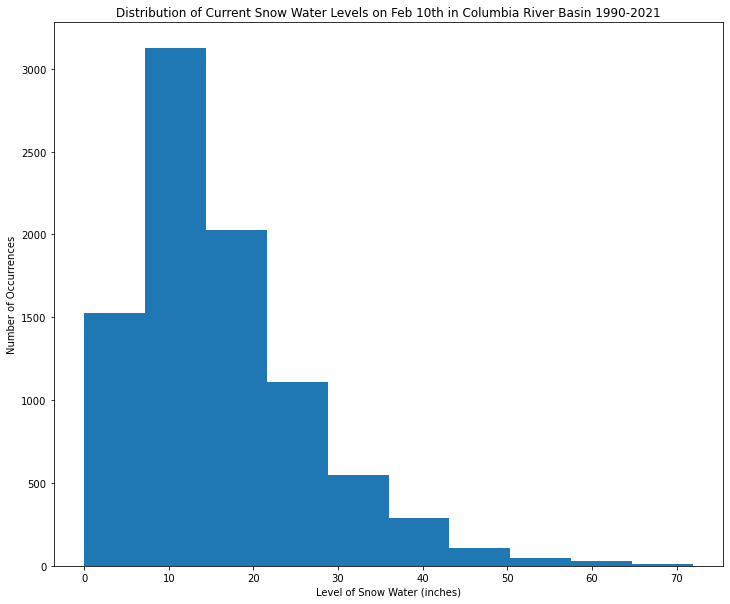

In [11]:
plt.figure(figsize=(12, 10))
plt.hist(allyears['wteq_amt'])
plt.title('Distribution of Current Snow Water Levels on Feb 10th in Columbia River Basin 1990-2021')
plt.xlabel('Level of Snow Water (inches)')
plt.ylabel('Number of Occurrences')
plt.style.use('ggplot')

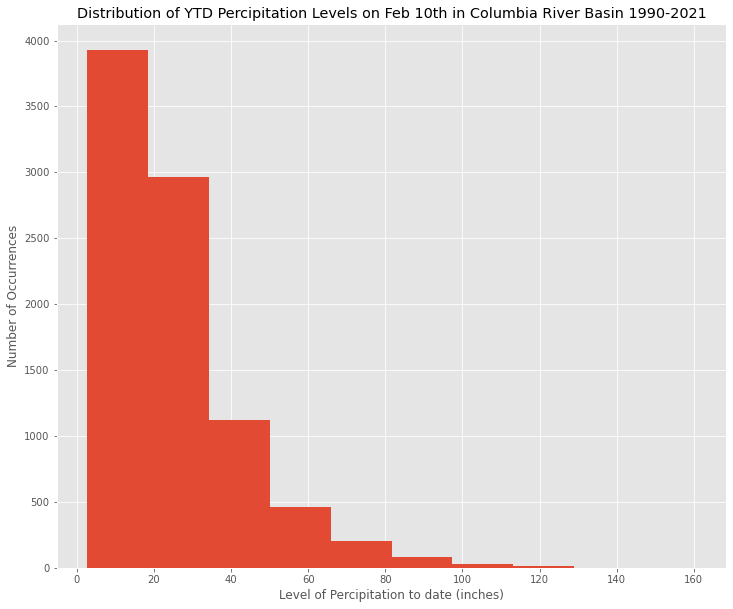

In [12]:
plt.figure(figsize=(12, 10))
plt.hist(allyears['prec_wytd_amt'])
plt.title('Distribution of YTD Percipitation Levels on Feb 10th in Columbia River Basin 1990-2021')
plt.xlabel('Level of Percipitation to date (inches)')
plt.ylabel('Number of Occurrences')
plt.style.use('ggplot')

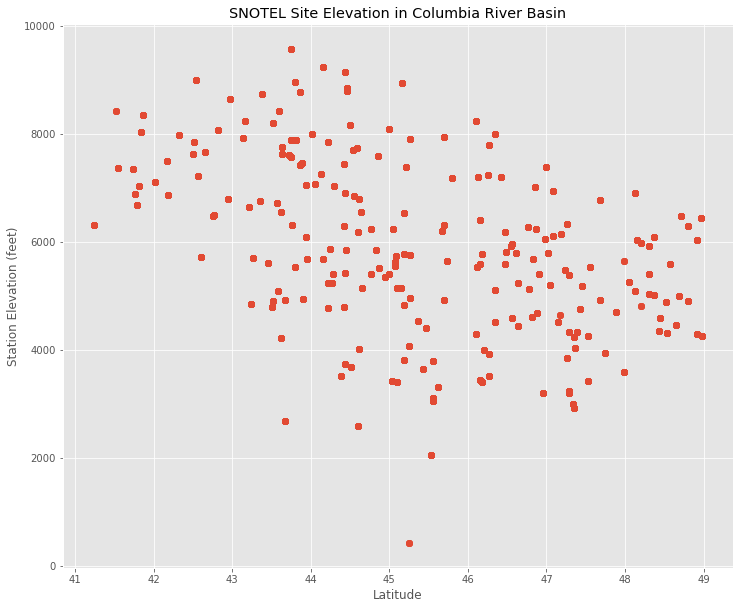

In [13]:
plt.figure(figsize=(12, 10))
plt.scatter(x=allyears['lat'], y=allyears['elevation'])
plt.title('SNOTEL Site Elevation in Columbia River Basin')
plt.xlabel('Latitude')
plt.ylabel('Station Elevation (feet)')

plt.style.use('ggplot')

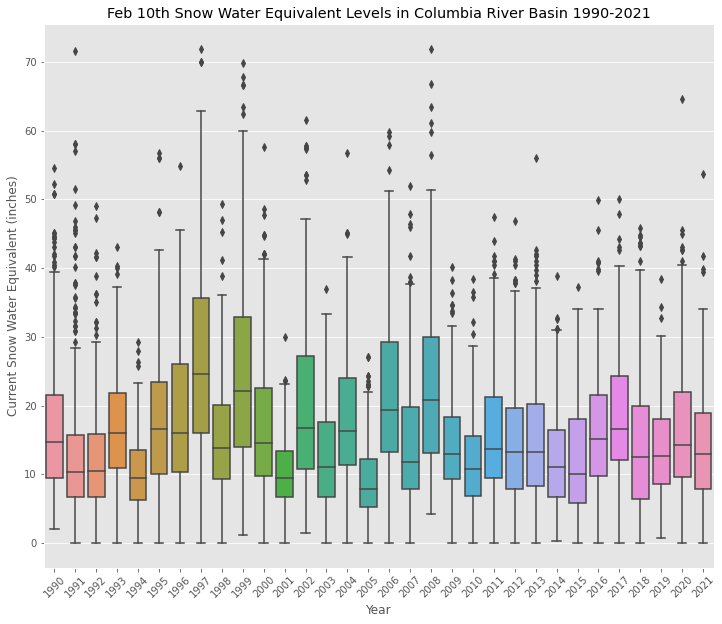

In [14]:
plt.figure(figsize=(12, 10))
sns.boxplot(x=allyears.index.year, y=allyears['wteq_amt'])
plt.title('Feb 10th Snow Water Equivalent Levels in Columbia River Basin 1990-2021')
plt.xlabel('Year')
plt.ylabel('Current Snow Water Equivalent (inches)')
plt.xticks(rotation = 45)
plt.style.use('ggplot')

Text(0, 0.5, 'Average Current Snow Water Equivalent (inches)')

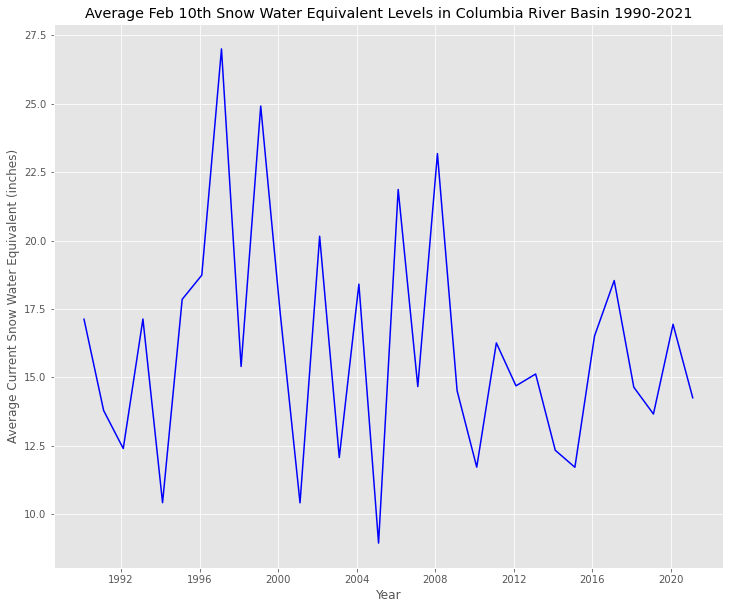

In [15]:
plt.figure(figsize=(12, 10))
plt.plot(allyears.groupby(allyears.index)['wteq_amt'].mean(), color='b')
plt.title(
    'Average Feb 10th Snow Water Equivalent Levels in Columbia River Basin 1990-2021')
plt.xlabel('Year')
plt.ylabel('Average Current Snow Water Equivalent (inches)')

## ARIMA Model

For our model we wanted to look at how well an ARIMA model would be able to predict the percipitation amount in each sub basin on February 10th. For this each sub basin was seperated into its own csv file, located in the basin-csvs folder.

#### Functions for modeling

In [16]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [17]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [18]:
def data_formatter(filename):
    """
    a function to read in basin csvs, set their index as a datetime object,
    and remove columns not needed for modeling.
    
    :param filename: The file name for the sub basin csv
    
    :return: dataframe for use in ARIMA model
    """
    # Read in CSV
    df = pd.read_csv(f'./basin_csvs/{filename}')
    # Converts yyyymmdd to datetime and sets as index
    df.set_index(pd.to_datetime(df['yyyymmdd']), inplace = True)
    # Making sure index is sorted
    df.sort_index(inplace = True)
    # Drops unneeded columns
    df.drop(columns = [
        'Unnamed: 0', 'yyyymmdd', 'lat','long','station_id','elevation'
    ],
            inplace = True)
    # Drop unneeded dummy columns
    df.drop(columns = df.columns[6:], inplace = True)
    return df

In [20]:
def basin_grouper(basin_df):
    """
    This function groups the observations by station in each basin
    by date and averages them.
    
    :param basin_df: Sub basin dataframe formatted by the data_formatter function
    
    :return: Grouped and averaged dataframe
    """
    df = pd.DataFrame(basin_df.groupby('yyyymmdd').mean())
    return df.asfreq(pd.DateOffset(years=1))

In [21]:
def arima_model(basin, name='BASIN NAME HERE'):
    """
    This function finds the best paramaters for and ARIMA model for each sub basin,
    returns the best paramaters, AIC, and plot of the model. Much of the code has
    been taken from the ARIMA lesson and has been modified for our use in this function.
    
    :param basin: Sub basin dataframe returned from the basin_grouper function
    :param name: Name of the sub basin from a list of the sub basin names
    
    :return: Best model parameters, AIC, and model plot
    """
    # Setting the X and y for our model, and splitting into train and test
    X = basin.drop(columns = 'wteq_amt')
    y = basin['wteq_amt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
    # Starting AIC, p, d, and q.
    best_aic = 99 * (10 ** 16)
    best_p = 0
    best_q = 0
    best_d = 0
    
    for p in range(5):
        for d in range(5):
            for q in range(5):
        
            # Insert try and except statements.
                try:
                    arima = ARIMA(endog=y_train, order=(p, d, q))

                    # Fit ARIMA model.
                    model = arima.fit()

                    # Is my current model's AIC better than our best_aic?
                    if model.aic < best_aic:
                    # If so, let's overwrite best_aic, best_p, and best_q.
                        best_aic = model.aic
                        best_p = p
                        best_d = d
                        best_q = q

                except:
                    pass
    
    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
    print(f'This model has an AIC of {best_aic}.')
    model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
    arima = model.fit()
    preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
    plt.figure(figsize=(10,6))

    # Plot training data.
    plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')

    # Plot testing data.
    plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')

    # Plot predicted test values.
    plt.plot(y_test.index, preds, color = 'green', label = 'prediction')

    plt.title(label = f'{name} Basin Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Snow Water Equivalent (inches)')
    plt.legend()
    plt.show();

In [22]:
# Formatting the individual sub basin dataframes

big_and_little_lost_basins_df = data_formatter('big_and_little_lost_basins.csv')
big_and_little_wood_basins_df = data_formatter('big_and_little_wood_basins.csv')
bitterroot_df = data_formatter('bitterroot.csv')
chelan_entiat_wenatchee_df = data_formatter('chelan_entiat_wenatchee.csv')
clearwater_and_salmon_df = data_formatter('clearwater_and_salmon.csv')
columbia_above_methow_df = data_formatter('columbia_above_methow.csv')
deschutes_crooked_john_day_df = data_formatter('deschutes_crooked_john_day.csv')
flathead_river_basin_df = data_formatter('flathead_river_basin.csv')
grand_ronde_df = data_formatter('grand_ronde_powder_burnt_imnaha.csv')
henrys_fork_df = data_formatter('henrys_fork_teton_willow_blackfoot_portneuf.csv')
idaho_panhandle_df = data_formatter('idaho_panhandle_region.csv')
kootenai_river_df = data_formatter('kootenai_river_in_montana.csv')
lewis_cowlitz_df = data_formatter('lewis_cowlitz.csv')
lower_clark_df = data_formatter('lower_clark_fork_river_basin.csv')
lower_columbia_df = data_formatter('lower_columbia_hood_river.csv')
owyhee_malheur_df = data_formatter('owyhee_malheur.csv')
raft_goose_salmon_falls_bruneau_df = data_formatter('raft_goose_salmon_falls_bruneau.csv')
snake_above_palisades_df = data_formatter('snake_above_palisades.csv')
umatilla_walla_walla_willow_df = data_formatter('umatilla_walla_walla_willow.csv')
upper_clark_fork_river_basin_df = data_formatter('upper_clark_fork_river_basin.csv')
weiser_payette_boise_df = data_formatter('weiser_payette_boise.csv')
white_green_cedar_skykomish_snoqualmi_baker_skagit_df = data_formatter('white_green_cedar_skykomish_snoqualmi_baker_skagit.csv')
willamette_df = data_formatter('willamette.csv')
yakima_ahtanum_df = data_formatter('yakima_ahtanum.csv')

In [23]:
big_and_little_lost_basins_df.head()

,acton_id,station_name,wteq_amt,wteq_med,wteq_amt_pct_med,prec_wytd_amt
yyyymmdd,,,,,,
1990-02-10,14F02S,Stickney Mill,4.0,5.4,74.0,6.9
1990-02-10,13E06S,Moonshine,6.7,6.4,105.0,8.9
1990-02-10,14F03S,Lost-Wood Divide,10.8,13.4,81.0,12.1
1990-02-10,13E27S,Hilts Creek,6.2,8.4,74.0,7.3
1990-02-10,13F03S,Bear Canyon,7.2,9.2,78.0,7.8


In [24]:
# Creating list of each basin name

basin_names = [
    "Big and Little Lost Basins", "Big and Little Wood Basins", "Bitterroot", "Chelan Entiat Wenatchee",
    "Clearwater and Salmon", "Columbia Above Methow", "Deschutes Crooked John Day", "Flathead River",
    "Grand Ronde", "Henrys Fork", "Idaho Panhandle", "Kootenai River", "Lewis Cowlitz", "Lower Clark",
    "Lower Columbia", "Owyhee Malheur", "Raft Goose Salmon Falls Bruneau", "Snake Above Palisades",
    "Umatilla Walla Walla Willow", "Upper Clark Fork River", "Weiser Payette Boise",
    "White Green Cedar Skykomish Snoqualmi Baker Skagit", "Willamette", "Yakima Ahtanum"
]

In [25]:
# Creating a list of grouped dataframes

big_and_little_lost_group_df = basin_grouper(big_and_little_lost_basins_df)
big_and_little_wood_group_df = basin_grouper(big_and_little_wood_basins_df)
bitterroot_group_df = basin_grouper(bitterroot_df)
chelan_group_df = basin_grouper(chelan_entiat_wenatchee_df)
clearwater_group_df = basin_grouper(clearwater_and_salmon_df)
columbia_group_df = basin_grouper(columbia_above_methow_df)
deschutes_group_df = basin_grouper(deschutes_crooked_john_day_df)
flathead_group_df = basin_grouper(flathead_river_basin_df)
grand_group_df = basin_grouper(grand_ronde_df)
henry_group_df = basin_grouper(henrys_fork_df)
idaho_group_df = basin_grouper(idaho_panhandle_df)
kootenai_group_df = basin_grouper(kootenai_river_df)
lewis_group_df = basin_grouper(lewis_cowlitz_df)
clark_group_df = basin_grouper(lower_clark_df)
columbia_group_df = basin_grouper(lower_columbia_df)
owyhee_group_df = basin_grouper(owyhee_malheur_df)
raft_group_df = basin_grouper(raft_goose_salmon_falls_bruneau_df)
snake_group_df = basin_grouper(snake_above_palisades_df)
umatilla_group_df = basin_grouper(umatilla_walla_walla_willow_df)
upper_clark_group_df = basin_grouper(upper_clark_fork_river_basin_df)
weiser_group_df = basin_grouper(weiser_payette_boise_df)
white_green_group_df = basin_grouper(white_green_cedar_skykomish_snoqualmi_baker_skagit_df)
wilamette_group_df = basin_grouper(willamette_df)
yakima_group_df  = basin_grouper(yakima_ahtanum_df)

# list of grouped dataframes

grouped_list = [
    big_and_little_lost_group_df,
    big_and_little_wood_group_df,
    bitterroot_group_df,
    chelan_group_df,
    clearwater_group_df,
    columbia_group_df,
    deschutes_group_df,
    flathead_group_df,
    grand_group_df,
    henry_group_df,
    idaho_group_df,
    kootenai_group_df,
    lewis_group_df,
    clark_group_df,
    columbia_group_df,
    owyhee_group_df,
    raft_group_df,
    snake_group_df,
    umatilla_group_df,
    upper_clark_group_df,
    weiser_group_df,
    white_green_group_df,
    wilamette_group_df,
    yakima_group_df
]

In [26]:
raft_group_df.head()

,wteq_amt,wteq_med,wteq_amt_pct_med,prec_wytd_amt
yyyymmdd,,,,
1990-02-10,10.00625,11.3375,84.250,10.5125
1991-02-10,7.71250,11.3375,66.500,7.9250
1992-02-10,7.43750,11.3375,62.500,8.7750
1993-02-10,15.02500,11.3375,132.875,14.2250
1994-02-10,6.77500,11.3375,58.375,7.4125


In [27]:
# Looking for stationarity with adfuller tests

for basin, name in zip(grouped_list, basin_names):
    print(name)
    print(interpret_dftest(adfuller(basin['wteq_amt'])))
    print()

Big and Little Lost Basins
Test Statistic   -1.504728
p-value           0.531171
dtype: float64

Big and Little Wood Basins
Test Statistic   -1.337205
p-value           0.611984
dtype: float64

Bitterroot
Test Statistic   -3.759448
p-value           0.003351
dtype: float64

Chelan Entiat Wenatchee
Test Statistic   -4.753450
p-value           0.000067
dtype: float64

Clearwater and Salmon
Test Statistic   -6.000310e+00
p-value           1.663442e-07
dtype: float64

Columbia Above Methow
Test Statistic   -6.554637e+00
p-value           8.677971e-09
dtype: float64

Deschutes Crooked John Day
Test Statistic   -6.844038e+00
p-value           1.761361e-09
dtype: float64

Flathead River
Test Statistic   -4.407058
p-value           0.000288
dtype: float64

Grand Ronde
Test Statistic   -7.315623e+00
p-value           1.231519e-10
dtype: float64

Henrys Fork
Test Statistic   -1.875563
p-value           0.343643
dtype: float64

Idaho Panhandle
Test Statistic   -6.637471e+00
p-value           5.51

Most sub basins look to be stationary and should not need diffing, though it will be included in the gridsearch.

In [28]:
# Dropping median columns if they are in the dataframes

for df in grouped_list:
    if 'wteq_amt_pct_med' in df.columns:
        df.drop(columns = ['wteq_amt_pct_med', 'wteq_med'], inplace = True)

#### ARIMA model for each sub basin

Big and Little Lost Basins
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,0).
This model has an AIC of 127.49412432821156.


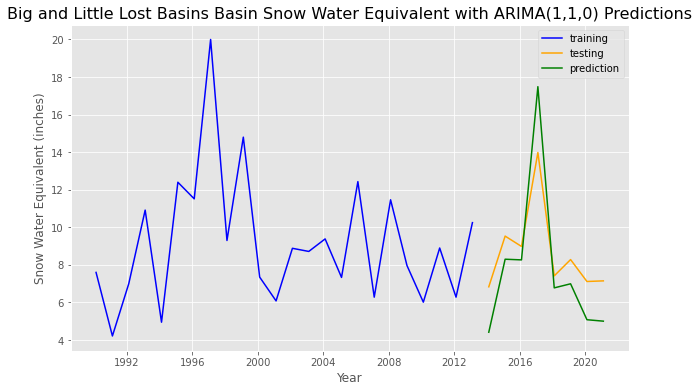


Big and Little Wood Basins
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,0).
This model has an AIC of 139.27493395422692.


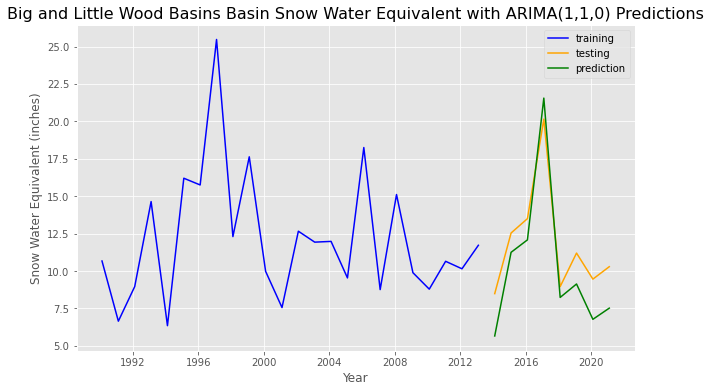


Bitterroot
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 141.51270557867403.


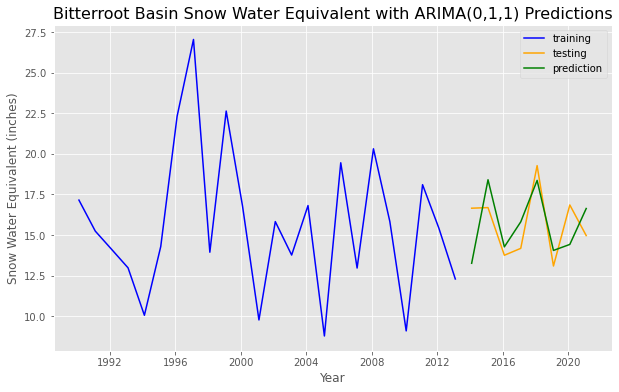


Chelan Entiat Wenatchee
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,4,4).
This model has an AIC of 18.0.


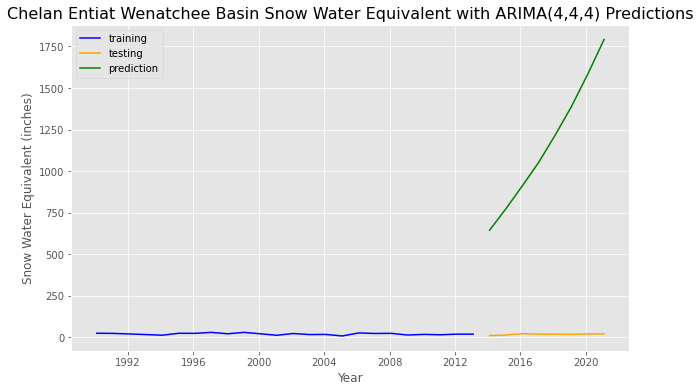


Clearwater and Salmon
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 147.84558789025328.


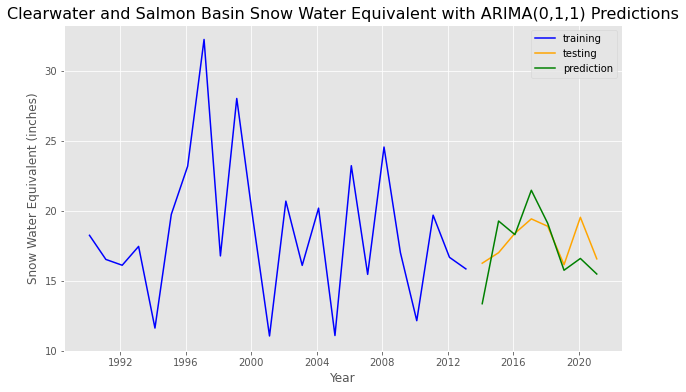


Columbia Above Methow
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 173.78548071414428.


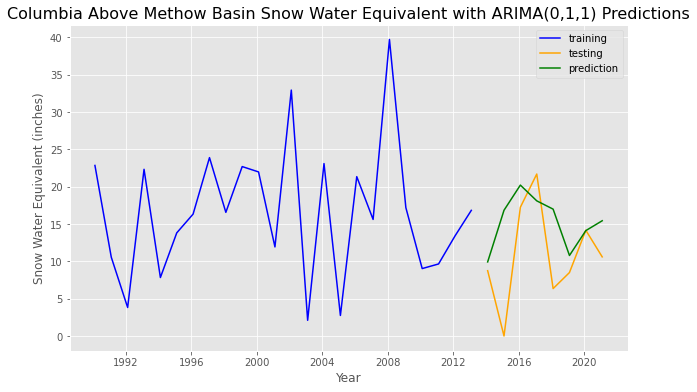


Deschutes Crooked John Day
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,0).
This model has an AIC of 139.94387097874585.


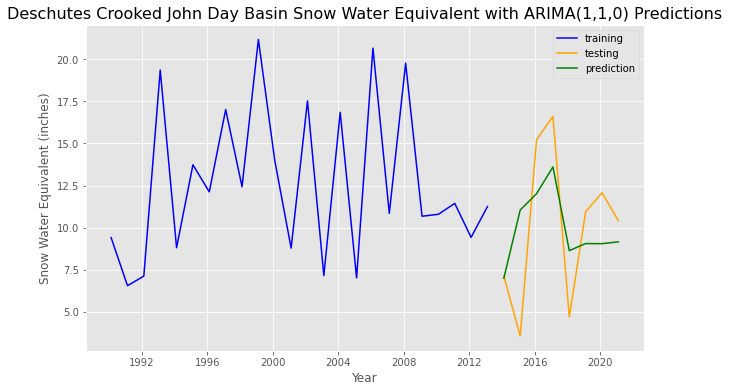


Flathead River
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,4,4).
This model has an AIC of 18.0.


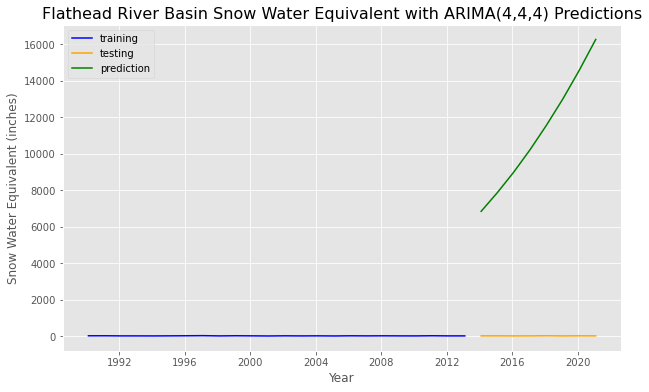


Grand Ronde
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,0).
This model has an AIC of 116.60542655551333.


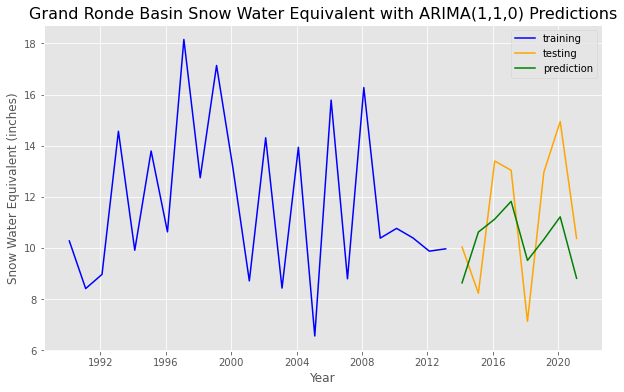


Henrys Fork
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,3).
This model has an AIC of 136.15850535506954.


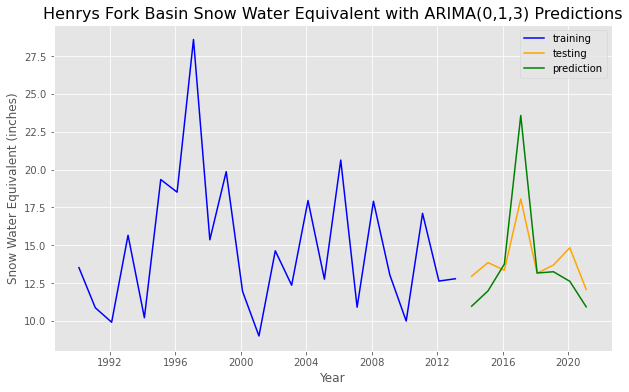


Idaho Panhandle
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 159.27883681686487.


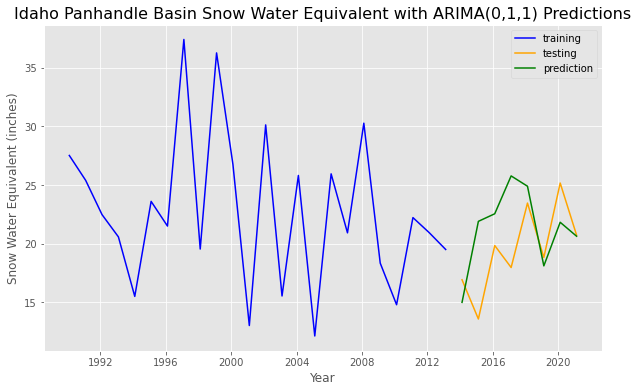


Kootenai River
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 143.34902231475888.


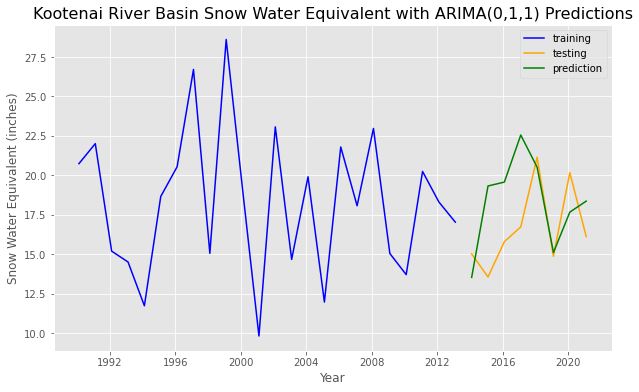


Lewis Cowlitz
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,0,1).
This model has an AIC of 180.92519820825902.


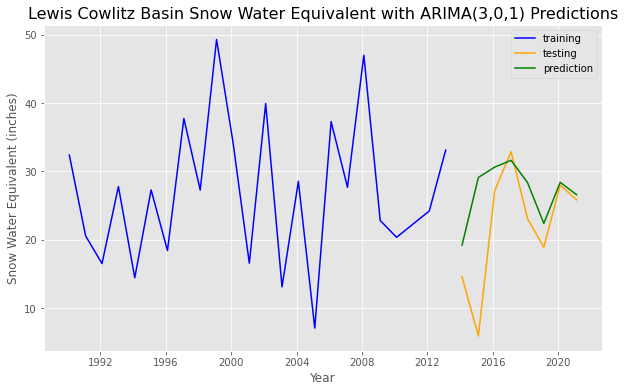


Lower Clark
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,4,2).
This model has an AIC of 12.0.


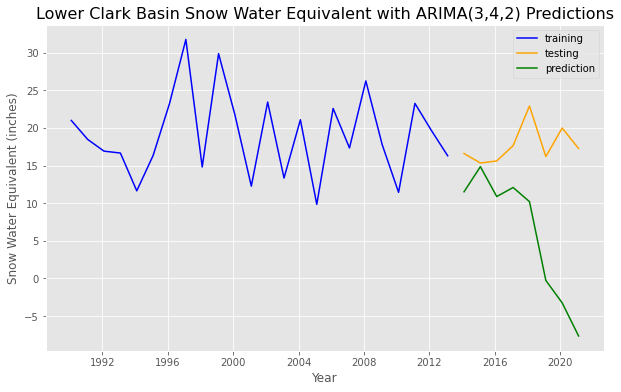


Lower Columbia
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 173.78548071414428.


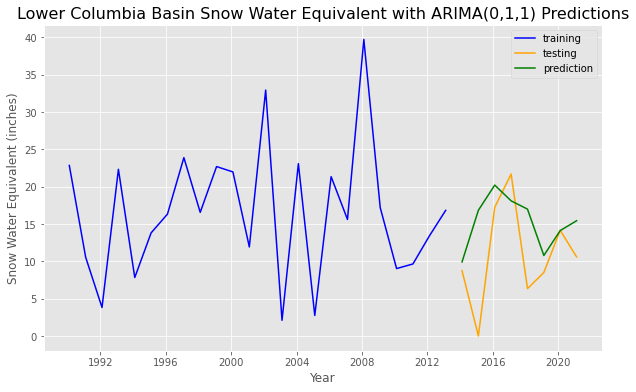


Owyhee Malheur
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,0,3).
This model has an AIC of 16.0.


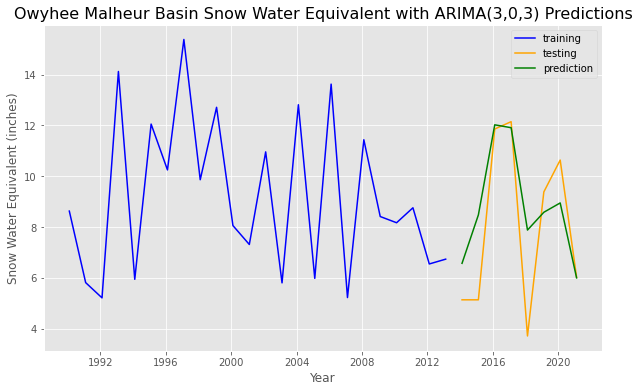


Raft Goose Salmon Falls Bruneau
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,0,2).
This model has an AIC of 132.03919014736942.


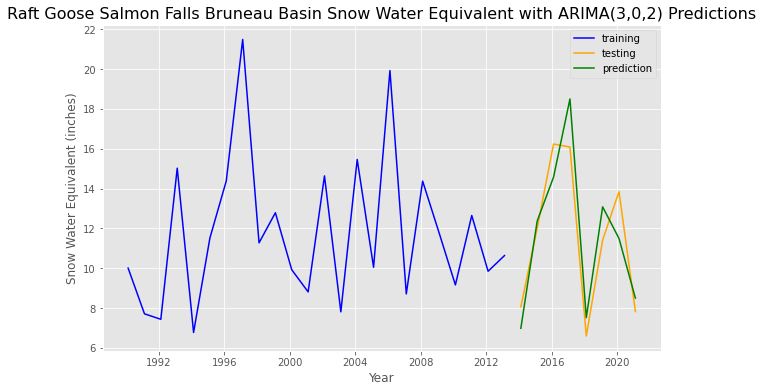


Snake Above Palisades
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 142.2460001271002.


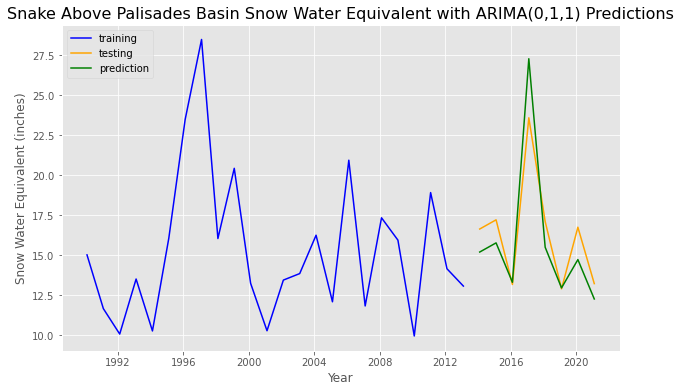


Umatilla Walla Walla Willow
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of 135.50516217546885.


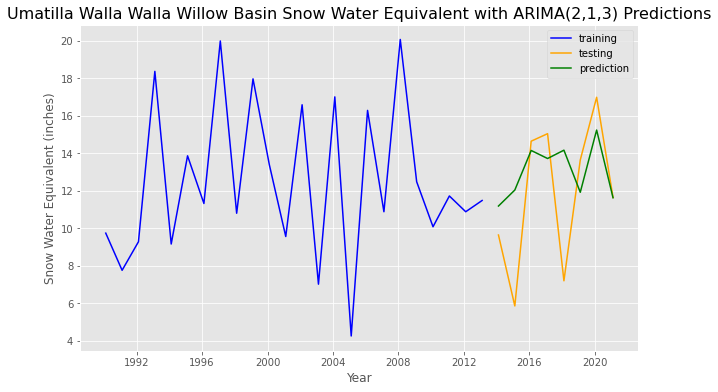


Upper Clark Fork River
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 120.02358667657073.


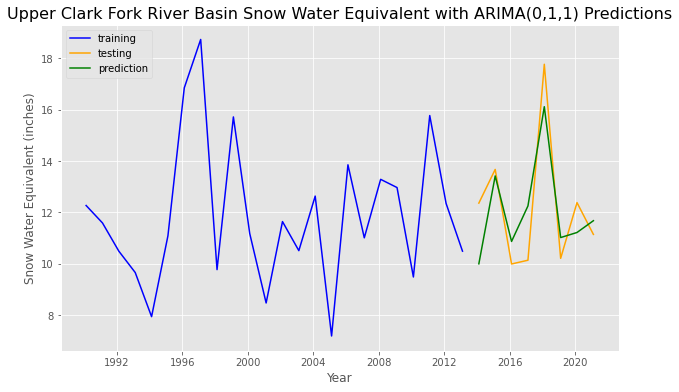


Weiser Payette Boise
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,0).
This model has an AIC of 151.40983353595786.


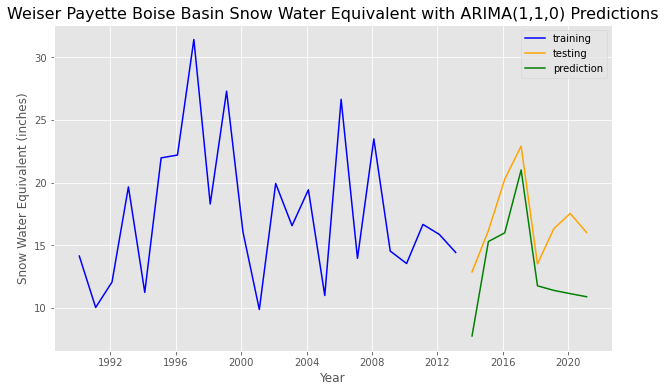


White Green Cedar Skykomish Snoqualmi Baker Skagit
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,0,3).
This model has an AIC of 165.21117255818967.


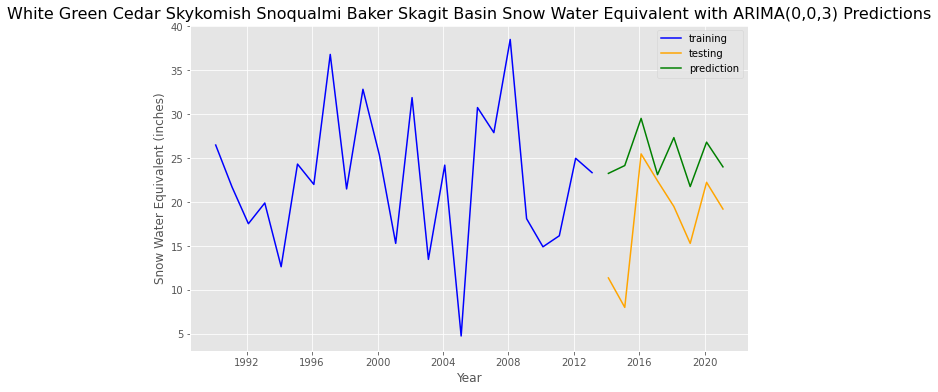


Willamette
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,1).
This model has an AIC of 164.71212235316875.


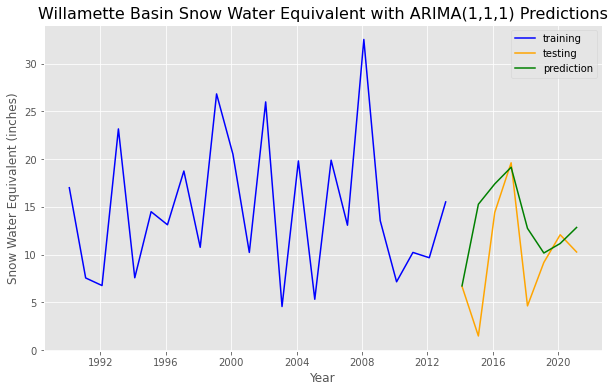


Yakima Ahtanum
MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 163.66634153945978.


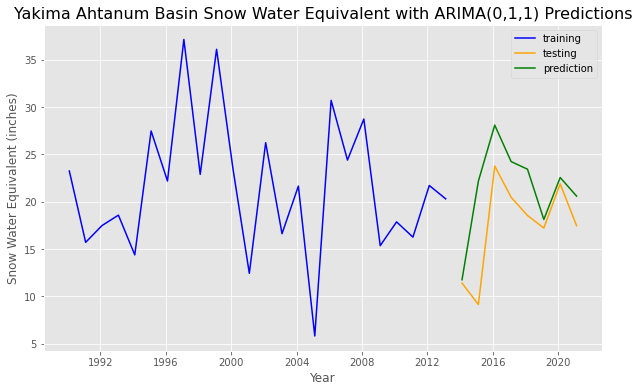

In [29]:
for df, name in zip(grouped_list, basin_names):
    print(name)
    arima_model(df, name)
    print()

Most of the models perform pretty well, with the exception of Chelan and Flathead, which seemed to fail. Overall though, it seems that these models could serve well for general predictions.

Chelan Entiat Wenatchee
MODEL FINISHED!
Our model that minimizes AIC on Chelan Entiat Wenatchee's training data is the ARIMA(4,4,4).
This model has an AIC of 18.0.
  


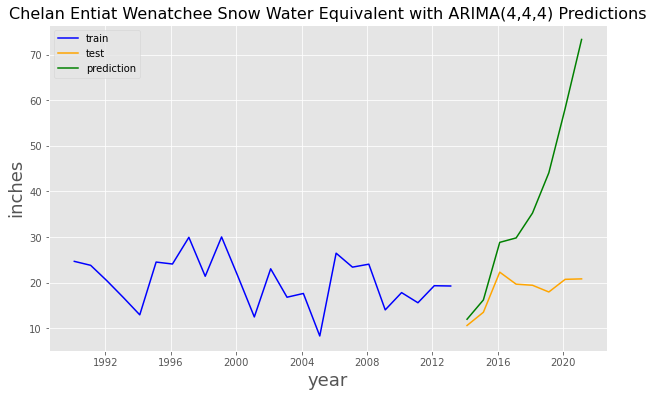


Flathead River
MODEL FINISHED!
Our model that minimizes AIC on Flathead River's training data is the ARIMA(4,4,4).
This model has an AIC of 18.0.
  


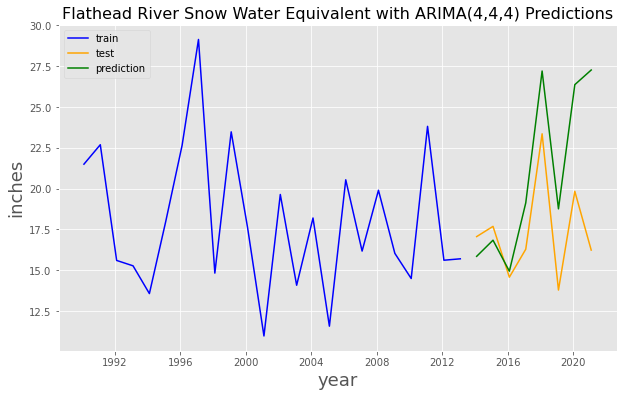


Lower Clark
MODEL FINISHED!
Our model that minimizes AIC on Lower Clark's training data is the ARIMA(3,4,2).
This model has an AIC of 12.0.
  


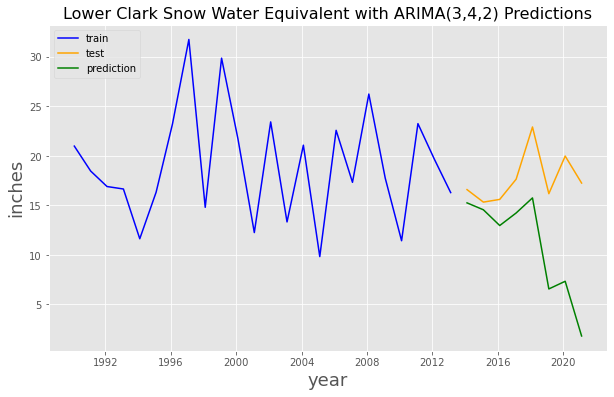

In [29]:
# Trying another approach for the models that failed, including the median columns in the dataframe

basins = ['chelan_entiat_wenatchee', 'flathead_river_basin', 'lower_clark_fork_river_basin']
basin_names_2 = ["Chelan Entiat Wenatchee", "Flathead River", "Lower Clark"]

basins_dict = {}

for basin in basins:
    temp = pd.read_csv(f'./basin_csvs/{basin}.csv').drop(['Unnamed: 0', 'lat', 'long'], axis=1)
    temp = temp.drop(temp.columns[-24:], axis=1)
    temp['yyyymmdd'] = pd.to_datetime(temp['yyyymmdd'])
    basins_dict[f'{basin[:-4]}_df'] = temp.set_index('yyyymmdd')
    

def arima_model_2(key, name): 
    df = basins_dict[key]
    
    #code from sam for basin grouper:
    df = pd.DataFrame(df.groupby('yyyymmdd').mean())
    df = df.asfreq(pd.DateOffset(years=1))
    
    # code modified from ARIMA lesson
    X = df.drop(columns = ['wteq_amt'])
    y = df['wteq_amt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
    
    # Starting AIC, p, d, and q.
    best_aic = 99 * (10 ** 16)
    best_p = 0
    best_q = 0
    best_d = 0

    # Use nested for loop to iterate over values of p and q.
    for p in range(5):
        for d in range(5):
            for q in range(5):

                # Insert try and except statements.
                try:
                    # Instantiate ARIMA model.
                    arima = ARIMA(endog=y_train, order=(p, d, q))
                    # Fit ARIMA model.
                    model = arima.fit()
                    # Is my current model's AIC better than our best_aic?
                    if model.aic < best_aic:
                        # If so, let's overwrite best_aic, best_p, and best_q.
                        best_aic = model.aic
                        best_p = p
                        best_d = d
                        best_q = q
                except:
                    pass
    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on {name}\'s training data is the ARIMA({best_p},{best_d},{best_q}).')
    print(f'This model has an AIC of {best_aic}.')
    print('  ')
    
    # Instantiate best model.
    model = ARIMA(endog=y_train, exog=X_train, order=(best_p, best_d, best_q))
    # Fit ARIMA model.
    arima = model.fit()
    # Generate predictions based on test set.
    preds = arima.predict(start=y_test.index[0], exog = X_test, end = y_test.index[-1])
    
    # Plot data.
    plt.figure(figsize=(10,6))
    plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label='train')
    plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'test')
    plt.plot(y_test.index, preds, color = 'green', label='prediction')
    
    plt.ylabel('inches', size=18)
    plt.xlabel('year', size=18)

    plt.title(f'{name} Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
    plt.legend(loc="upper left")
    plt.show();    
    
    
for key, name in zip(basins_dict, basin_names_2):
    print(name)
    arima_model_2(key, name)
    print()

The models did not fail here, but there were some interesting predictions for the Chelan Basin. Overall this still shows that these models can be useful for these predictions.

## Conclusions and Recommendations

Our models show that ARIMA models can be useful in predicting percipitation levels at SNOTEL sites. Our models were only tested for predictions on one day of the year, similar results should be seen when testing on other days of the year as well. We would recommend for further testing and use of the full data for every day of the year before implementing a model for short term predictions.